In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime
import numpy as np

In [2]:
#Страница Wiki с актуальным списком тикеров S&P500
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#External_links"
response=requests.get(wikiurl)

In [3]:
#Ищем нужную нам таблицу на странице
soup = BeautifulSoup(response.text, 'html.parser')
sp500table=soup.find(id="constituents")

In [4]:
#Создаем DataFrame
df=pd.read_html(str(sp500table))
df=pd.DataFrame(df[0])
print(df.head())

  Symbol             Security SEC filings             GICS Sector  \
0    MMM                   3M     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV               AbbVie     reports             Health Care   
3   ABMD              Abiomed     reports             Health Care   
4    ACN            Accenture     reports  Information Technology   

                GICS Sub-Industry    Headquarters Location Date first added  \
0        Industrial Conglomerates    Saint Paul, Minnesota       1976-08-09   
1           Health Care Equipment  North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois       2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts       2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland       2011-07-06   

       CIK      Founded  
0    66740         1902  
1     1800         1888  
2  1551152  2013 (1888)  
3   81

In [5]:
#Далее исторические данные будем брать с Yahoo! Finance, поэтому в некоторых тикерах надо поменять "." на "-"
tickers = [tick.replace('.', '-') for tick in df['Symbol'].tolist()] 
len(tickers) #проверяем, что все наши 505 тикеров на месте

505

Для скачивания данных по тикерам нашел билиотеку **yfinance**. К сожалению, тут есть проблема, которую я не успел решить: не для всех тикеров есть значения цены в одни и те же даты. К примеру, для тикера ABBV есть данные в 09 месяц, но нет данных в 10, при том что на самом сайте данные отображаются. Скорее всего, нужно выбрать другой способ запарсить исторические данные

In [154]:
dateStart=datetime.date(datetime.date.today().year-10,datetime.date.today().month+1,1)
dateStop=datetime.date(datetime.date.today().year,datetime.date.today().month+1,1)
data=yf.download(tickers,dateStart,dateStop,interval='3mo',auto_adjust=True)['Close']#cкачиваем данные по составу индекса
sp500=yf.download('^GSPC',dateStart,dateStop,interval='3mo',auto_adjust=True)['Close'] #скачиваем данные по индексу

[*********************100%***********************]  505 of 505 completed
[*********************100%***********************]  1 of 1 completed


In [155]:
#Из-за вышеописанной проблемы придется удалять тикеры с NaN
data=data.dropna(thresh=450).dropna(axis=1, how='all')

In [156]:
datachanges4=data.pct_change(periods=4)#доходность за предыдущие 4 квартала, на ее основе будет отбирать компании
datachanges=data.pct_change()#доходность за каждый квартал, по ней считаем профит
sp500changes=sp500.dropna().pct_change() #считаем доходность индекса

In [163]:
#первую закупку делаем 2012-09-01, первый профит "снимаем" 2012-12-01 (спустя 1 квартал)
Bank=1000 #для абсолютных значение примем стартовый капитал равным 1000$
times = list(data.index)[4:] #даты, в которые мы торгуем
compare = pd.DataFrame() #создаем DataFrame для сравнение квартальной доходности
for i in range(len(times)-1):
    profit=0 #в начале каждого квартала обнуляем соответствующие доходности
    sp500profit=0
    period=times[i].strftime("%Y-%m-%d") #создаем ключ для работы с DataFrame; период, в котором отбираем топ-100
    periodnext=times[i+1].strftime("%Y-%m-%d") #ключ для работы с DataFrame; период, когда считаем доходность купленных ранее активов
    bought=datachanges4.loc[period].sort_values(ascending=False)[0:100] #список купленных тикеров (отсортированных по доходности за квартал)
    for asset in list(bought.index): 
        profit+=datachanges[asset].loc[periodnext]/len(bought) #суммируем доходности всех купленных активов, т.к. они были куплены в равных долях
    sp500profit=sp500changes.loc[periodnext] #доходность индекса за квартал 
    compare = pd.concat([compare,pd.DataFrame([[profit, sp500profit]], 
                                              columns=['Strategy\'s Profit','S&P500 Profit'], 
                                              index=[periodnext])]) #Записываем доходность в каждом квартале
answer=(compare+1).cumprod() #считаем доходность по сложному проценту
aar=((compare+1).groupby(compare.reset_index().index // 4).prod()-1).mean() #AAR - Average Annual Return

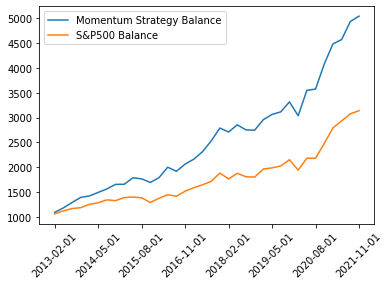

In [162]:
plt=(answer*Bank).plot(); #строим абсолютные значения баланса нашего портфеля
plt.legend(["Momentum Strategy Balance", "S&P500 Balance"]);
plt.set_xticklabels(plt.get_xticklabels(),rotation=45);

В условии было сказано про данные "за последние 10 лет". Но первый год мы "наблюдаем", чтобы понять, какие компании "показали наибольшую доходность за 4 предыдущих квартала". Поэтому в итоге мы анализируем данные за 9 лет. Соотвественно, в волатильности тоже используем 9 лет.

In [164]:
volatility=answer.std()/(9**0.5) #считаем волатильность

Формируем итоговую таблицу согласно условию задания. Формат выбран такой, что в случае тестирования новых стратегий, эти данные можно будет легко добавить последней строкой и получить общую обзорную таблицу.

In [165]:
finalTable=pd.DataFrame(np.array([[answer.loc[periodnext][1]*Bank, 
                                   answer.loc[periodnext][1]*100, volatility[1]*100,
                                   aar[1]*100], 
                                  [answer.loc[periodnext][0]*Bank, 
                                   answer.loc[periodnext][0]*100, volatility[0]*100,
                                   aar[0]*100]]), 
                        columns=['Abs. Profit,$','Percent. Profit,%', 'Volatility,%','AAR,%'], 
                        index=['S&P500','Momentum Strategy'])
print(finalTable)

                   Abs. Profit,$  Percent. Profit,%  Volatility,%      AAR,%
S&P500               3138.260880         313.826088     18.496610  14.033346
Momentum Strategy    5035.745954         503.574595     36.181033  20.351974
